In [1]:
import torch
import torch.nn as nn 
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import sys

from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mnist')

In [2]:
device = 'cpu'

In [3]:
input_size = 784
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = .001

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

C:\Users\Dhruv\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

In [6]:
example = iter(train_loader)
samples, labels = example.next()
print(samples.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


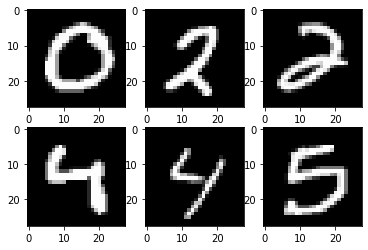

In [7]:
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)

In [8]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.L1 = nn.Linear(input_size, hidden_size)
        self.Relu = nn.ReLU()
        self.L2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self,x):
        output = self.L1(x)
        output = self.Relu(output)
        return self.L2(output)

In [9]:
model = NeuralNet(input_size, hidden_size, num_classes)

In [10]:
loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer.add_graph(model, samples.reshape(-1,28*28))

In [11]:
running_loss = .0
running_correct_prediction = 0
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i,(img, label) in enumerate(test_loader):
        img = img.reshape(-1,28*28)
        
        out = model(img)
        l = loss(out, labels)
                
        l.backward()
        optim.step()
        optim.zero_grad()
        
        running_loss += l.item()
        _, predictions = torch.max(out,1)

        running_correct_prediction += (predictions == label).sum().item()
        
        
        if (i+1)%100 == 0 :
            print(f'epoch {epoch+1}/{num_epochs} : step{i+1} loss = {l.item():.4f}')
            writer.add_scalar('training loss', running_loss/100, epoch*n_total_steps + i)
            writer.add_scalar('training accuracy', running_correct_prediction/100, epoch*n_total_steps + i)
            
            running_loss = .0
            running_correct_prediction = 0
            
            writer.close()

epoch 1/2 : step100 loss = 2.2060
epoch 1/2 : step200 loss = 2.2406
epoch 1/2 : step300 loss = 2.2457
epoch 1/2 : step400 loss = 2.2042
epoch 1/2 : step500 loss = 2.2597
epoch 1/2 : step600 loss = 2.2341
epoch 2/2 : step100 loss = 2.1962
epoch 2/2 : step200 loss = 2.2308
epoch 2/2 : step300 loss = 2.2387
epoch 2/2 : step400 loss = 2.2038
epoch 2/2 : step500 loss = 2.2541
epoch 2/2 : step600 loss = 2.2327


In [16]:
labels = []
preds = []
with torch.no_grad():
    n_correct = 0
    n_sample = 0
    
    for img, lbls in test_loader:
        img = img.reshape(-1,28*28)

        out = model(img)
        
        _, predictions = torch.max(out,1)
        
        n_sample +=lbls.shape[0]
        n_correct += (predictions == lbls).sum().item()
        
        class_predictions = [nn.functional.softmax(output, dim=0) for output in out]
        preds.append(class_predictions)
        labels.append(predictions)
        
    class_preds = torch.cat([torch.stack(batch) for batch in preds])
    class_labels = torch.cat(labels)
        
        
    acc = 100.0 * n_correct/n_sample
    print(acc)
    
    classes = range(10)
    for i in classes:
        labels_i = class_labels == i
        preds_i = class_preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()

10.925
